# Data

In [1]:
from pathlib import Path
import pandas as pd
FILE_DIR = Path().resolve().parent
DATA_DIR = FILE_DIR / "2_models"


train_df = pd.read_pickle(f"{DATA_DIR}/train_df.pkl")
val_df = pd.read_pickle(f"{DATA_DIR}/val_df.pkl")

print(f"Train DataFrame shape: {train_df.shape}")
print(f"Validation DataFrame shape: {val_df.shape}")

Train DataFrame shape: (5252, 4)
Validation DataFrame shape: (927, 4)


In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [3]:
def compute_stft_batch(x, n_fft=256, hop_length=128):
    stft = torch.stft(
        x, n_fft=n_fft, hop_length=hop_length,
        return_complex=True
    )
    return torch.abs(stft)  


In [4]:

from torch.utils.data import DataLoader
set_seed(42)

# STDFT function to compute the Short-Time Fourier Transform (STFT) for a batch of signals
# It convert into time -frequency representation
# n_fft: size of the FFT window(300 hz is the sampling rate, so 256 is a good choice to capture more than 1 heart beat)
# hop_length: number of samples between successive frames (128 is a good choice since every window will overlap by 50%)

# 2. Model
class ECGModel(nn.Module):
    def __init__(self,hidden_size=128, dropout_rate=0.0):
        super(ECGModel, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

        # RNN
        self.rnn = nn.GRU(
            input_size=32 * 32, # out_channels * frequency_bins // 2 // 2 (due to max pooling) ()
            hidden_size= hidden_size,
            batch_first=True
        )

        # Fully connected
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 4)  # 4 classes: Normal, AF, Other, Noisy

    def forward(self, x:torch.Tensor)-> torch.Tensor:
        # x: (batch_size, signal_length)
        #print("Input:", x.shape)
        x = compute_stft_batch(x)  # STFT → (batch, freq, time)
        #print("After STFT:", x.shape)
        x = torch.log1p(x)  # logarithmic scaling
        #print("After log1p:", x.shape)
        

        x = x.unsqueeze(1)  # CNN input shape: (batch, channel, freq, time)
        #print("After Unsqueeze:", x.shape)

        x = self.conv1(x)
        x = self.conv2(x)
        #print("After conv2:", x.shape)

        # Flatten the output for RNN input
        b, c, f, t = x.shape  # batch, channel, freq, time
        x = x.view(b, c * f, t)  # (batch, features, time)
        #print("After view:", x.shape)
        x = x.permute(0, 2, 1)   # (batch, time, features)
        #print("After permute:", x.shape)

        # RNN
        output, h_n = self.rnn(x)
        #print("After RNN output:", output.shape)
        x = self.dropout(h_n[-1])
        x = self.fc(x)  # use the last hidden state for classification
        #print("Final output:", x.shape)
        return x


In [5]:
set_seed(42)
def pad_or_trim(signal, target_length=9000):
    current_length = len(signal)

    if current_length < target_length:
        # Pad with zeros at the end
        padding = target_length - current_length
        signal = np.pad(signal, (0, padding), 'constant')
    elif current_length > target_length:
        # Trim from center
        start = (current_length - target_length) // 2
        signal = signal[start : start + target_length]

    return signal

def time_shift(signal, shift_max=100):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(signal, shift)


def scale_amplitude(signal, scale_range=(0.95, 1.05)):
    scale = np.random.uniform(*scale_range)
    return signal * scale

def add_noise(signal, noise_level=0.001):
    noise = np.random.normal(0, noise_level * np.std(signal), size=signal.shape)
    return signal + noise

In [6]:
from torch.utils.data import Dataset
class ECGDataset(Dataset):
    def __init__(self, df, target_length=9000):
        self.df = df
        self.target_length = target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Signal processing
        # Pad or trim the signal to the target length
        signal = pad_or_trim(row['signal'], self.target_length)
        signal = torch.tensor(signal, dtype=torch.float32)
        label = int(row['label']) 

        return signal, label

In [7]:
set_seed(42)
from torch.utils.data import DataLoader
def train_one_epoch(model:nn.Module, 
                    dataloader:DataLoader, 
                    optimizer:torch.optim.Optimizer, 
                    loss_fn:nn.Module):
    """
    Trains the model for one full epoch.

    Args:
        model: The neural network model (ECGModel).
        dataloader: The training DataLoader providing batches.
        optimizer: The optimizer (e.g., Adam).
        loss_fn: The loss function (e.g., CrossEntropyLoss).

    Returns:
        A tuple of (average_loss, accuracy) for the epoch.
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for signals, labels in dataloader:

        outputs = model(signals)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * signals.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [8]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_score, recall_score,accuracy_score

def evaluate_with_metrics(model:nn.Module, dataloader, loss_fn):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for signals, labels in dataloader:
            outputs = model(signals)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])
    report = classification_report(
    all_labels, all_preds,
    labels=[0, 1, 2, 3],
    target_names=['Normal', 'AF', 'Other', 'Noisy'],
    zero_division=0  # uyarı vermesin
)

    return avg_loss, accuracy, f1, precision, cm, report


## Augmentation

In [ ]:
# Aug_dict = {
#     "noise": add_noise,
#     "shift": time_shift,
#     "scale": scale_amplitude
# }


In [17]:
Aug_dict = {
    "noise": add_noise,
    "scale": scale_amplitude
}


In [18]:
def create_augmented_df(train_df, augment_func, augment_name):
    augmented_data = []
    for i, row in train_df.iterrows():
        signal = pad_or_trim(row["signal"])
        signal = np.array(signal) 
        label = row["label"]
        rr_std = row["rr_std"]

        # Sadece normal sınıfı augment etme!
        if label == 0 or label == 1 or label == 3:
            continue

        aug_signal = augment_func(signal.copy())
        aug_signal = pad_or_trim(aug_signal)

        augmented_data.append({
            "signal": aug_signal.tolist(),
            "label": label,
            "length": 9000,
            "rr_std": rr_std,
            "augment_type": augment_name
        })

    # Orijinal datayı da ekle
    train_df["signal"] = train_df["signal"].apply(pad_or_trim)
    train_df["length"] = 9000
    train_df["augment_type"] = "original"

    # Augmented + orijinal veriyi birleştir
    full_df = pd.concat([train_df, pd.DataFrame(augmented_data)], ignore_index=True)
    return full_df


In [19]:
full_train_df = create_augmented_df(train_df, add_noise, "noise")
print(" Full train DataFrame shape:", full_train_df.shape)
print(" Validation DataFrame shape:", val_df.shape)
print(full_train_df["label"].value_counts().sort_index())

 Full train DataFrame shape: (6753, 5)
 Validation DataFrame shape: (927, 4)
label
0    3094
1     465
2    3002
3     192
Name: count, dtype: int64


In [20]:
from sklearn.utils.class_weight import compute_class_weight
def calculate_class_weights(df) -> torch.Tensor:
    """
    Calculate class weights for the given DataFrame.
    
    Args:
        df: DataFrame containing 'label' column with class labels.
        
    Returns:
        A dictionary mapping class labels to their corresponding weights.
    """
    set_seed(42)
    # Compute class weights based on the training labels
    original_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1, 2, 3]),
        y=df['label'].values
    )

    scaled_weights = original_weights / original_weights.max()  # normalize to max=1
    scaled_weights = 0.5 + (scaled_weights * 0.5)  # shrink range to [0.5, 1.0] for balance
    weights_tensor = torch.tensor(scaled_weights, dtype=torch.float32)
    return weights_tensor




In [14]:
num_epochs = 15

In [21]:
import copy
import pandas as pd

results = []

def aug_test(train_df,aug_dict):
    for aug_name, aug_func in aug_dict.items():
        print(f"\n--- AUGMENTATION: {aug_name} ---\n")

        # Augment edilmiş + orijinal seti oluştur
        full_train_df = create_augmented_df(train_df, aug_func, aug_name)
        
        weights_tensor = calculate_class_weights(full_train_df)

        # Dataset ve DataLoader
        train_dataset = ECGDataset(full_train_df)
        val_dataset = ECGDataset(val_df)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(42))
        val_loader = DataLoader(val_dataset, batch_size=32)

        # Model ve optimizer
        model = ECGModel(hidden_size=256, dropout_rate=0.3)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
        loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)

        # Training
        best_val_f1 = 0
        patience = 5
        counter = 0
        best_model_state = None

        for epoch in range(num_epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn)
            val_loss, val_acc, val_f1, val_precision, cm, val_report = evaluate_with_metrics(model, val_loader, loss_fn)

            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
            print(f"Val   F1: {val_f1:.4f} | Val Precision: {val_precision:.4f}")
            print("-" * 40)
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_model_state = copy.deepcopy(model.state_dict())
                counter = 0
            else:
                counter += 1
                print(f"EarlyStopping Counter: {counter} / {patience}")
                if counter >= patience:
                    print("Early stopping triggered!")
                    break

        # Sonuçları kaydet
        results.append({
            "augmentation": aug_name,
            "best_val_f1": best_val_f1,
            "best_val_acc": val_acc,
            "conf_matrix": cm,
            "val_report": val_report
        })
        model.load_state_dict(best_model_state)
        val_loss, val_acc, val_f1, val_precision, val_cm, val_report = evaluate_with_metrics(model, val_loader, loss_fn)
        print(f"Validation F1 Score: {val_f1:.4f}")
        print("Confusion Matrix:\n", val_cm)
        print("Classification Report:\n", val_report)
        print("vall acc:", val_acc)


    # Sonuç tablosu
    results_df = pd.DataFrame(results)
    print("\n\nAUGMENTATION Result:\n")
    print(results_df[["augmentation", "best_val_f1", "best_val_acc"]])


## Augmentation test

In [22]:
aug_test(train_df, Aug_dict)


--- AUGMENTATION: noise ---



c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/15
Train Loss: 1.0681 | Train Acc: 0.4746
Val   Loss: 1.0484 | Val   Acc: 0.4725
Val   F1: 0.2516 | Val Precision: 0.2578
----------------------------------------


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/15
Train Loss: 0.9900 | Train Acc: 0.5581
Val   Loss: 0.9556 | Val   Acc: 0.6192
Val   F1: 0.3184 | Val Precision: 0.3519
----------------------------------------


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/15
Train Loss: 0.9276 | Train Acc: 0.5937
Val   Loss: 0.9793 | Val   Acc: 0.5307
Val   F1: 0.3558 | Val Precision: 0.4036
----------------------------------------


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/15
Train Loss: 0.8963 | Train Acc: 0.6141
Val   Loss: 0.8666 | Val   Acc: 0.6365
Val   F1: 0.3005 | Val Precision: 0.3587
----------------------------------------
EarlyStopping Counter: 1 / 5
Epoch 5/15
Train Loss: 0.9092 | Train Acc: 0.6006
Val   Loss: 0.8257 | Val   Acc: 0.6419
Val   F1: 0.4094 | Val Precision: 0.6162
----------------------------------------
Epoch 6/15
Train Loss: 0.8588 | Train Acc: 0.6276
Val   Loss: 1.0133 | Val   Acc: 0.4531
Val   F1: 0.2817 | Val Precision: 0.6088
----------------------------------------
EarlyStopping Counter: 1 / 5
Epoch 7/15
Train Loss: 0.8375 | Train Acc: 0.6416
Val   Loss: 0.7804 | Val   Acc: 0.6688
Val   F1: 0.4929 | Val Precision: 0.6581
----------------------------------------
Epoch 8/15
Train Loss: 0.8142 | Train Acc: 0.6504
Val   Loss: 0.7780 | Val   Acc: 0.6731
Val   F1: 0.4960 | Val Precision: 0.6813
----------------------------------------
Epoch 9/15
Train Loss: 0.8008 | Train Acc: 0.6533
Val   Loss: 0.8394 | Val   Acc: 0.650

c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/15
Train Loss: 1.0804 | Train Acc: 0.4539
Val   Loss: 1.0679 | Val   Acc: 0.3376
Val   F1: 0.1680 | Val Precision: 0.2215
----------------------------------------


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/15
Train Loss: 1.0177 | Train Acc: 0.5088
Val   Loss: 0.9731 | Val   Acc: 0.6052
Val   F1: 0.3272 | Val Precision: 0.3614
----------------------------------------


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/15
Train Loss: 0.9756 | Train Acc: 0.5547
Val   Loss: 0.9317 | Val   Acc: 0.6106
Val   F1: 0.3490 | Val Precision: 0.3610
----------------------------------------


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/15
Train Loss: 0.9507 | Train Acc: 0.5716
Val   Loss: 0.8668 | Val   Acc: 0.6278
Val   F1: 0.3201 | Val Precision: 0.3909
----------------------------------------
EarlyStopping Counter: 1 / 5


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/15
Train Loss: 0.9608 | Train Acc: 0.5632
Val   Loss: 0.8729 | Val   Acc: 0.6127
Val   F1: 0.3492 | Val Precision: 0.3714
----------------------------------------


KeyboardInterrupt: 

# Oversampling

In [21]:
# get every class total in train set
class_totals = train_df['label'].value_counts().sort_index()
class_totals

label
0    3094
1     465
2    1501
3     192
Name: count, dtype: int64

In [53]:
from sklearn.utils import resample

def oversample_minority_classes(df, target_count=1500):
    oversampled_dfs = []

    for label in sorted(df["label"].unique()):
        class_df = df[df["label"] == label]
        if len(class_df) < target_count:
            # Oversample: tekrar ederek arttır
            resampled = resample(
                class_df,
                replace=True,
                n_samples=target_count,
                random_state=42
            )
        else:
            resampled = class_df
        oversampled_dfs.append(resampled)

    return pd.concat(oversampled_dfs, ignore_index=True)


In [ ]:
balanced_train_df = oversample_minority_classes(train_df)


print(balanced_train_df['label'].value_counts())


label
0    3094
2    1501
1    1500
3    1500
Name: count, dtype: int64


In [28]:
new_aug_dict = {
    "noise": add_noise,
    "scale": scale_amplitude
}
aug_test(balanced_train_df, new_aug_dict)


--- AUGMENTATION: noise ---

Epoch 1/10
Train Loss: 1.1562 | Train Acc: 0.4441
Val   Loss: 1.3435 | Val   Acc: 0.4412
Val   F1: 0.3597 | Val Precision: 0.3892
----------------------------------------
Epoch 2/10
Train Loss: 0.8896 | Train Acc: 0.6035
Val   Loss: 1.0736 | Val   Acc: 0.5286
Val   F1: 0.4985 | Val Precision: 0.4666
----------------------------------------
Epoch 3/10
Train Loss: 0.7910 | Train Acc: 0.6517
Val   Loss: 0.9670 | Val   Acc: 0.5836
Val   F1: 0.4979 | Val Precision: 0.4911
----------------------------------------
EarlyStopping Counter: 1 / 5
Epoch 4/10
Train Loss: 0.6749 | Train Acc: 0.7054
Val   Loss: 0.8472 | Val   Acc: 0.6537
Val   F1: 0.5477 | Val Precision: 0.5561
----------------------------------------
Epoch 5/10
Train Loss: 0.5641 | Train Acc: 0.7567
Val   Loss: 0.8955 | Val   Acc: 0.6138
Val   F1: 0.5390 | Val Precision: 0.5389
----------------------------------------
EarlyStopping Counter: 1 / 5
Epoch 6/10
Train Loss: 0.4561 | Train Acc: 0.8080
Val   L

# HeartPY

In [3]:
pip install heartpy

  Using cached heartpy-1.2.7-py3-none-any.whl.metadata (9.5 kB)
Using cached heartpy-1.2.7-py3-none-any.whl (1.0 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import heartpy as hp

def extract_heartpy_features(signal):
    try:
        signal = np.array(signal)
        wd, m = hp.process(signal, sample_rate=300, bpmmax=250,bpmmin=30)
        features = [
            m["sdnn"],
            m["rmssd"],
            m["pnn50"],
            m["hr_mad"],
        ]
        return features
    except Exception as e:
        print("Hata:", e)
        return [0.0] * 4
 


[-1255 -1488 -1745 -2015 -2253 -2374 -2379 -2286 -2241 -2129]
9000


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\heartpy\visualizeutils.py:119: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


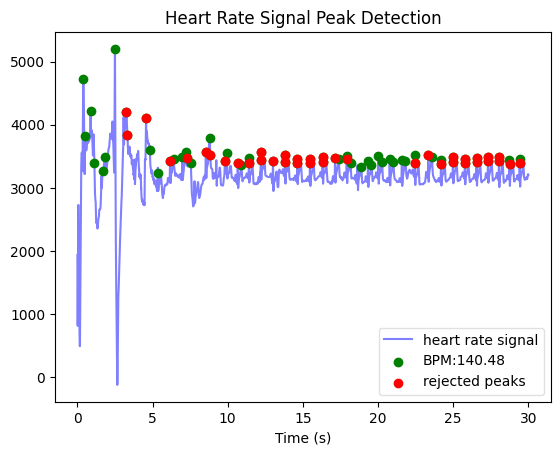

In [7]:
test_signal = np.array(train_df.iloc[1]["signal"])
print(test_signal[:10])  # ilk 10 değere bak
print(len(test_signal))  # uzunluk 9000 mi?

# normalize etmeden önce deneyelim:
wd, m = hp.process(test_signal, sample_rate=300, bpmmax=250,bpmmin=30)
hp.plotter(wd, m)  # sinyali görsel olarak incele


In [23]:
import heartpy as hp
import numpy as np
import pandas as pd


# Yeni özellikleri taşıyacak liste
features = []

# Her sinyal için özellik çıkar
for i in range(len(train_df)):
    signal = np.array(train_df.iloc[i]["signal"])
    features.append(extract_heartpy_features(signal))

# DataFrame'e çevir
heartpy_features_df = pd.DataFrame(
    features,
    columns=["sdnn", "rmssd", "pnn50", "hr_mad"]
)

# Label ve varsa ID gibi bilgileri kopyala
heartpy_features_df["label"] = train_df["label"].values
heartpy_features_df["signal"] = train_df["signal"].values



c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\heartpy\analysis.py:677: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  interp = UnivariateSpline(x, rrlist, k=3)
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:5317: RuntimeWarning: Mean of empty slice.
  result = super().m

⚠️ Hata: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------

⚠️ Hata: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------



c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\heartpy\analysis.py:677: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  interp = UnivariateSpline(x, rrlist, k=3)


⚠️ Hata: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------

⚠️ Hata: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------

⚠️ Hata: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detect

In [24]:
heartpy_features_df.head()

,sdnn,rmssd,pnn50,hr_mad,label,signal
0,170.246640,258.472364,0.90,120.000000,2,"[-446, -541, -637, -733, -819, -858, -867, -87..."
1,178.846742,318.708040,1.00,140.000000,0,"[-1255, -1488, -1745, -2015, -2253, -2374, -23..."
2,6.317256,6.195469,0.00,5.000000,0,"[156, 189, 223, 255, 291, 330, 362, 380, 390, ..."
3,106.118876,144.705960,0.75,83.333333,1,"[-22, -27, -33, -38, -40, -39, -36, -30, -23, ..."
4,14.915399,18.362046,0.00,13.333333,0,"[291, 345, 405, 465, 510, 527, 516, 509, 507, ..."


In [25]:
# Tüm özellik sütunlarının sıfır olduğu satırları filtrele
heartpy_columns =["sdnn", "rmssd", "pnn50", "hr_mad"]

zero_feature_rows = (heartpy_features_df[heartpy_columns] == 0).all(axis=1)

# Kaç tane?
num_zero_rows = zero_feature_rows.sum()

print(f"Tüm özellikleri 0 olan örnek sayısı: {num_zero_rows}")
print(f"Toplam örnek sayısı: {len(heartpy_features_df)}")
print(f" Oran: %{(num_zero_rows / len(heartpy_features_df)) * 100:.2f}")


Tüm özellikleri 0 olan örnek sayısı: 6
Toplam örnek sayısı: 5252
 Oran: %0.11


In [26]:
val_features = []
for i in range(len(val_df)):
    signal = np.array(val_df.iloc[i]["signal"])
    features = extract_heartpy_features(signal)
    val_features.append(features)

heartpy_val_df = pd.DataFrame(
    val_features,
    columns=["sdnn", "rmssd", "pnn50", "hr_mad"]
)
heartpy_val_df['label'] = val_df['label'].values
heartpy_val_df['signal'] = val_df['signal'].values

heartpy_val_df.head()

c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\heartpy\analysis.py:677: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  interp = UnivariateSpline(x, rrlist, k=3)
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:5317: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty sl

⚠️ Hata: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------



c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\heartpy\analysis.py:677: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  interp = UnivariateSpline(x, rrlist, k=3)


,sdnn,rmssd,pnn50,hr_mad,label,signal
0,116.874101,162.127065,1.000000,83.333333,2,"[-90, -105, -113, -114, -114, -115, -115, -115..."
1,78.672316,120.614369,0.434783,30.000000,2,"[116, 140, 168, 183, 189, 194, 198, 201, 203, ..."
2,135.950157,211.139388,0.842857,86.666667,2,"[-89, -109, -121, -128, -139, -149, -140, -122..."
3,209.793814,376.290971,0.918919,58.333333,2,"[-429, -505, -593, -683, -748, -771, -748, -73..."
4,178.508370,281.137396,0.794118,80.000000,2,"[16, 18, 19, 21, 23, 25, 27, 28, 29, 31, 32, 3..."


# new model

In [27]:
class ECGModelWithHeartFeatures(nn.Module):
    def __init__(self, hidden_size=128, dropout_rate=0.2):
        super().__init__()

        # STFT + CNN + RNN kısmı (aynı)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.rnn = nn.GRU(input_size=32 * 32, hidden_size=hidden_size, batch_first=True)

        # HeartPy features → 8 boyutlu vektör
        self.feature_fc = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Birleştir ve sınıflandır
        self.final_fc = nn.Sequential(
            nn.Linear(hidden_size + 32, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 4)
        )

    def forward(self, signal, features):
        x:torch.Tensor = compute_stft_batch(signal)     # (B, F, T)
        x = torch.log1p(x)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        b, c, f, t = x.shape
        x = x.view(b, c * f, t).permute(0, 2, 1)
        _, h_n = self.rnn(x)
        x_rnn = h_n[-1]

        x_feat = self.feature_fc(features)

        x_combined = torch.cat([x_rnn, x_feat], dim=1)
        return self.final_fc(x_combined)


In [28]:
from torch.utils.data import Dataset
class ECGDatasetWithFeatures(Dataset):
    def __init__(self, df):
        self.df = df
        self.signals = df["signal"].values
        self.labels = df["label"].values
        self.features = df[["sdnn", "rmssd", "pnn50", "hr_mad"]].values.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Signal processing
        # Pad or trim the signal to the target length
        signal = pad_or_trim(row['signal'], 9000)
        signal = torch.tensor(signal, dtype=torch.float32)
        label = self.labels[idx]
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        return signal, features, label

In [29]:
from torch.utils.data import DataLoader

In [30]:
heartpy_features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
heartpy_features_df.fillna(0.0, inplace=True)  # Alternatif: df.fillna(df.median(), inplace=True)


In [31]:
heartpy_val_df.replace([np.inf, -np.inf], np.nan, inplace=True)
heartpy_val_df.fillna(0.0, inplace=True)  # Alternatif: df.fillna(df.median(), inplace=True)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = ["sdnn", "rmssd", "pnn50", "hr_mad"]

heartpy_features_df[features] = scaler.fit_transform(heartpy_features_df[features])


In [33]:
scaler = StandardScaler()
features = ["sdnn", "rmssd", "pnn50", "hr_mad"]

heartpy_val_df[features] = scaler.fit_transform(heartpy_val_df[features])

In [34]:
train_dataset = ECGDatasetWithFeatures(heartpy_features_df)
val_dataset = ECGDatasetWithFeatures(heartpy_val_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val_dataset, batch_size=32)


In [35]:
def train_one_epoch_new(model, dataloader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for signals, features, labels in dataloader:
        signals = signals.float()
        features = features.float()
        labels = labels.long()

        optimizer.zero_grad()
        outputs = model(signals, features)

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * signals.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [36]:
from sklearn.metrics import f1_score, precision_score, confusion_matrix, classification_report

def evaluate_with_metrics_new(model, dataloader, loss_fn):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for signals, features, labels in dataloader:
            signals = signals.float()
            features = features.float()
            labels = labels.long()

            outputs = model(signals, features)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item() * signals.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.tolist())
            all_preds.extend(predicted.tolist())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    return epoch_loss, epoch_acc, val_f1, val_precision, cm, report


In [37]:
from sklearn.utils.class_weight import compute_class_weight
original_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array([0, 1, 2, 3]),
            y=heartpy_features_df['label'].values
        )
scaled_weights = original_weights / original_weights.max()
scaled_weights = 0.5 + (scaled_weights * 0.5)
weights_tensor = torch.tensor(scaled_weights, dtype=torch.float32)

In [45]:
import copy


model = ECGModelWithHeartFeatures(hidden_size=256, dropout_rate=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)

# Training
best_val_f1 = 0
patience = 5
counter = 0
best_model_state = None
num_epochs = 15

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch_new(model, train_loader, optimizer, loss_fn)
    val_loss, val_acc, val_f1, val_precision, cm, val_report = evaluate_with_metrics_new(model, val_loader, loss_fn)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print(f"Val   F1: {val_f1:.4f} | Val Precision: {val_precision:.4f}")
    print("-" * 40)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"EarlyStopping Counter: {counter} / {patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            break

c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1/15
Train Loss: 1.0878 | Train Acc: 0.5765
Val   Loss: 0.9884 | Val   Acc: 0.5804
Val   F1: 0.2367 | Val Precision: 0.2030
----------------------------------------


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 2/15
Train Loss: 1.0471 | Train Acc: 0.5861
Val   Loss: 0.9764 | Val   Acc: 0.5782
Val   F1: 0.2310 | Val Precision: 0.1919
----------------------------------------
EarlyStopping Counter: 1 / 5


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 3/15
Train Loss: 1.0321 | Train Acc: 0.5851
Val   Loss: 0.9750 | Val   Acc: 0.5836
Val   F1: 0.2148 | Val Precision: 0.1975
----------------------------------------
EarlyStopping Counter: 2 / 5


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 4/15
Train Loss: 1.0203 | Train Acc: 0.5878
Val   Loss: 0.9557 | Val   Acc: 0.5793
Val   F1: 0.2096 | Val Precision: 0.1780
----------------------------------------
EarlyStopping Counter: 3 / 5


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 5/15
Train Loss: 1.0066 | Train Acc: 0.5847
Val   Loss: 0.9379 | Val   Acc: 0.5858
Val   F1: 0.2141 | Val Precision: 0.1902
----------------------------------------
EarlyStopping Counter: 4 / 5


c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 6/15
Train Loss: 0.9862 | Train Acc: 0.5891
Val   Loss: 0.8996 | Val   Acc: 0.5901
Val   F1: 0.2421 | Val Precision: 0.3501
----------------------------------------
Epoch 7/15
Train Loss: 0.9555 | Train Acc: 0.6000
Val   Loss: 0.8560 | Val   Acc: 0.6170
Val   F1: 0.3314 | Val Precision: 0.4978
----------------------------------------
Epoch 8/15
Train Loss: 0.9245 | Train Acc: 0.6192
Val   Loss: 0.9906 | Val   Acc: 0.5394
Val   F1: 0.3801 | Val Precision: 0.5987
----------------------------------------
Epoch 9/15
Train Loss: 0.8938 | Train Acc: 0.6333
Val   Loss: 0.7895 | Val   Acc: 0.6505
Val   F1: 0.4152 | Val Precision: 0.5346
----------------------------------------
Epoch 10/15
Train Loss: 0.8407 | Train Acc: 0.6594
Val   Loss: 0.8006 | Val   Acc: 0.6408
Val   F1: 0.5299 | Val Precision: 0.5433
----------------------------------------
Epoch 11/15
Train Loss: 0.8139 | Train Acc: 0.6759
Val   Loss: 0.7312 | Val   Acc: 0.6807
Val   F1: 0.5601 | Val Precision: 0.5887
-------------

In [ ]:
model.load_state_dict(best_model_state)
val_loss, val_acc, val_f1, val_precision, val_cm, val_report = evaluate_with_metrics_new(model, val_loader, loss_fn)
print(f"Validation F1 Score: {val_f1:.4f}")
print("Confusion Matrix:\n", val_cm)
print("Classification Report:\n", val_report)


Validation F1 Score: 0.5852
Confusion Matrix:
 [[493   8  40   3]
 [ 20  39  19   6]
 [129  16 115   4]
 [  7   1  12  15]]
Classification Report:
               precision    recall  f1-score   support

           0     0.7596    0.9062    0.8265       544
           1     0.6094    0.4643    0.5270        84
           2     0.6183    0.4356    0.5111       264
           3     0.5357    0.4286    0.4762        35

    accuracy                         0.7141       927
   macro avg     0.6307    0.5587    0.5852       927
weighted avg     0.6973    0.7141    0.6963       927



# model result

In [57]:
balanced_train_df = oversample_minority_classes(heartpy_features_df)


print(balanced_train_df['label'].value_counts())


label
0    3094
2    1501
1    1500
3    1500
Name: count, dtype: int64


In [58]:
original_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array([0, 1, 2, 3]),
            y=balanced_train_df['label'].values
        )
scaled_weights = original_weights / original_weights.max()
scaled_weights = 0.5 + (scaled_weights * 0.5)
weights_tensor = torch.tensor(scaled_weights, dtype=torch.float32)

In [59]:

model = ECGModelWithHeartFeatures(hidden_size=256, dropout_rate=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)
train_dataset = ECGDatasetWithFeatures(balanced_train_df)
val_dataset = ECGDatasetWithFeatures(heartpy_val_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val_dataset, batch_size=32)


In [ ]:
best_val_f1 = 0
patience = 5
counter = 0
best_model_state = None
num_epochs = 15

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch_new(model, train_loader, optimizer, loss_fn)
    val_loss, val_acc, val_f1, val_precision, cm, val_report = evaluate_with_metrics_new(model, val_loader, loss_fn)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print(f"Val   F1: {val_f1:.4f} | Val Precision: {val_precision:.4f}")
    print("-" * 40)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        print(f"EarlyStopping Counter: {counter} / {patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            break

c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epoch 1/15
Train Loss: 1.2421 | Train Acc: 0.4616
Val   Loss: 1.2076 | Val   Acc: 0.4488
Val   F1: 0.2992 | Val Precision: 0.2531
----------------------------------------
Epoch 2/15
Train Loss: 1.0708 | Train Acc: 0.5325
Val   Loss: 0.9670 | Val   Acc: 0.5804
Val   F1: 0.3782 | Val Precision: 0.5714
----------------------------------------
Epoch 3/15
Train Loss: 0.9985 | Train Acc: 0.5895
Val   Loss: 0.9751 | Val   Acc: 0.5491
Val   F1: 0.4257 | Val Precision: 0.5051
----------------------------------------
Epoch 4/15
Train Loss: 0.8945 | Train Acc: 0.6409
Val   Loss: 1.0490 | Val   Acc: 0.5286
Val   F1: 0.4494 | Val Precision: 0.5113
----------------------------------------
Epoch 5/15
Train Loss: 0.8588 | Train Acc: 0.6519
Val   Loss: 0.8660 | Val   Acc: 0.6289
Val   F1: 0.5338 | Val Precision: 0.5212
----------------------------------------
Epoch 6/15
Train Loss: 0.8034 | Train Acc: 0.6757
Val   Loss: 0.8593 | Val   Acc: 0.6030
Val   F1: 0.4770 | Val Precision: 0.5147
---------------

In [ ]:
# save model as a file
import torch
torch.save(model.state_dict(), "ecg_model_with_heart_features.pth")


In [51]:
# load model from a file
model = ECGModelWithHeartFeatures(hidden_size=256, dropout_rate=0.3)
model.load_state_dict(torch.load("ecg_model_with_heart_features.pth"))
val_loss, val_acc, val_f1, val_precision, val_cm, val_report = evaluate_with_metrics_new(model, val_loader, loss_fn)
print(f"Validation F1 Score: {val_f1:.4f}")
print("Confusion Matrix:\n", val_cm)
print("Classification Report:\n", val_report)

Validation F1 Score: 0.6567
Confusion Matrix:
 [[480  12  46   6]
 [ 11  48  20   5]
 [ 92  20 146   6]
 [  5   2   6  22]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8163    0.8824    0.8481       544
           1     0.5854    0.5714    0.5783        84
           2     0.6697    0.5530    0.6058       264
           3     0.5641    0.6286    0.5946        35

    accuracy                         0.7508       927
   macro avg     0.6589    0.6588    0.6567       927
weighted avg     0.7441    0.7508    0.7451       927



In [48]:
model.load_state_dict(best_model_state)
val_loss, val_acc, val_f1, val_precision, val_cm, val_report = evaluate_with_metrics_new(model, val_loader, loss_fn)
print(f"Validation F1 Score: {val_f1:.4f}")
print("Confusion Matrix:\n", val_cm)
print("Classification Report:\n", val_report)


Validation F1 Score: 0.6567
Confusion Matrix:
 [[480  12  46   6]
 [ 11  48  20   5]
 [ 92  20 146   6]
 [  5   2   6  22]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8163    0.8824    0.8481       544
           1     0.5854    0.5714    0.5783        84
           2     0.6697    0.5530    0.6058       264
           3     0.5641    0.6286    0.5946        35

    accuracy                         0.7508       927
   macro avg     0.6589    0.6588    0.6567       927
weighted avg     0.7441    0.7508    0.7451       927

